# Notebook to look at linearity

Initially written 02 Sep 2020 by Craig Lage.\
This notebook was used to test the spline fit proposed by Astier et.al.\
in the DM environment

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep cp_pipe
! eups list -s | grep obs_lsst

lsst_distrib          20.0.0-1-g0037e03+e1f41a530d 	current w_2020_33 setup
cp_pipe               20.0.0-7-g3c4151b+eb42c07937 	current w_2020_33 setup
obs_lsst              19.0.0-83-gf414b51+347570b790 	current w_2020_33 setup
obs_lsst_data         20.0.0-1-g3fe583d 	current w_2020_33 setup


In [2]:
import sys, os, glob, time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.interpolate as interp
import astropy.io.fits as pf
from lsst.daf.persistence import Butler

In [3]:
# Get the data.  This was run with code that multiplied the expTime by the MONDIODE
# inside measurePhotonTransferCurve.py
REPO_DIR = '/project/shared/BOT/rerun/cslage/PTC_6790D_Linearizer2_R22S11'
RUN = '6790D'
[RAFT, SENSOR, DETECTOR] = ['R22', 'S11', 94]

In [4]:
butler = Butler(REPO_DIR)
ptcDataset = butler.get('photonTransferCurveDataset', raftName=RAFT, detector=DETECTOR)

amp = 'C04'
means = np.array(ptcDataset.rawMeans[amp])
vars = np.array(ptcDataset.rawVars[amp])
gain = ptcDataset.gain[amp]
expTimes = np.array(ptcDataset.rawExpTimes[amp])

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in true_divide


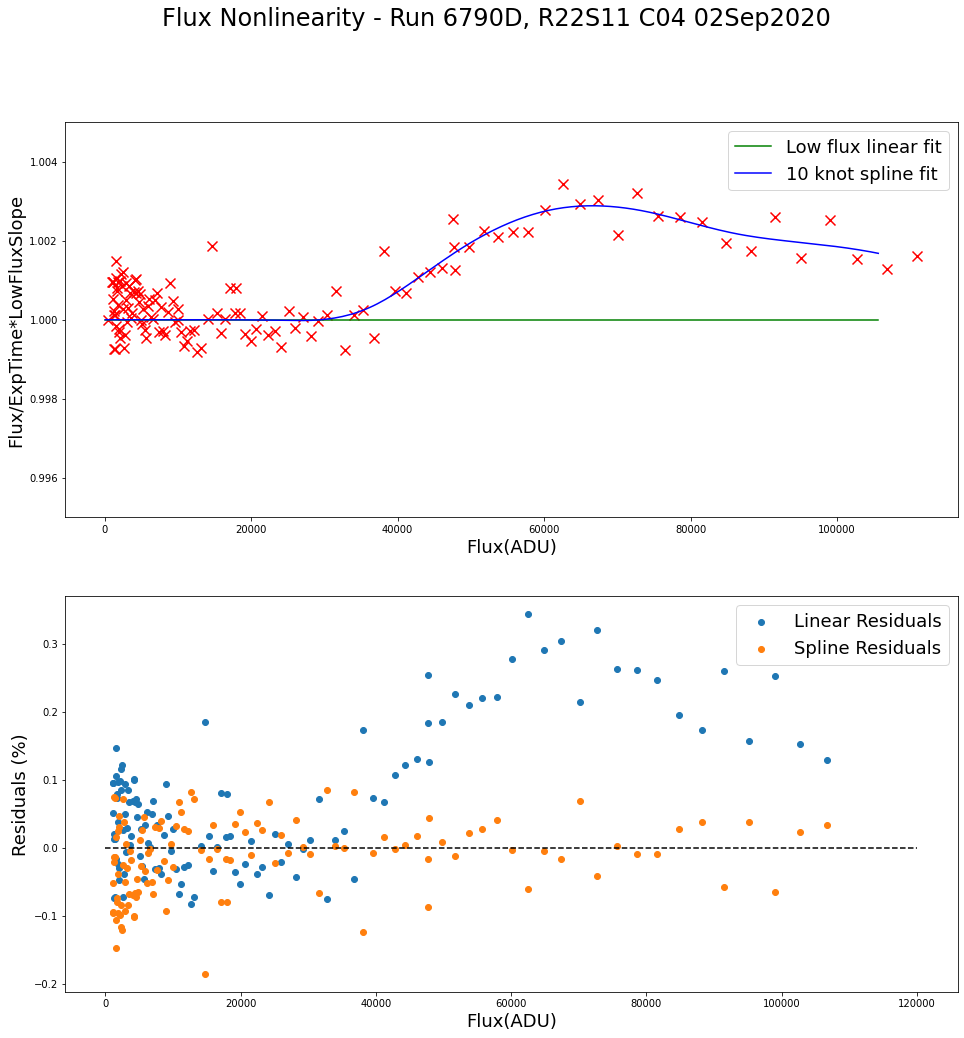

In [10]:
flux_max_e = 110000  # electrons
flux_max = flux_max_e / gain # In ADU

# First, we weed out some NaN values.  The points with flux<1000.0
# used a different neutral density filter and are not usable without
# some manipulation
goodIndex = np.where((~np.isnan(means)) & (means > 1000.0))
means = means[goodIndex]
expTimes = expTimes[goodIndex]
vars = vars[goodIndex]

# Now fit a line to the points with flux < 20000 ADU
lin_index = np.where(means < 20000)
coefs = np.polyfit(expTimes[lin_index], means[lin_index], 1)
slope = coefs[0]

# Now we assume that this extrapolated line represents the "true" flux
# and we model deviations from this to correct the measured flux
model_flux = slope * expTimes

# This is for plotting the deviations from linearity at higher flux
lin_residuals = (model_flux - means) / means * 100.0
xplot = np.linspace(100.0,flux_max, 200)
yplot = np.ones_like(xplot)

# The spline fit requires sorting the points
# The spline model will give us the "true" flux as a 
# function of the measured flux
index = expTimes.argsort()
means = means[index]
expTimes = expTimes[index]
vars = vars[index]

knots = 10 # Number of knots in the fit. Pierre recommends 10, but could use less.
xx = means
yy = model_flux

# Force the spline to match the linear fit at low flux by adding 
# highly weighted points at low flux
force_points = np.array([0.0,500.0,5000.0,10000.0])
xx = np.insert(xx, 0, force_points)
yy = np.insert(yy, 0, force_points)
weights = np.ones_like(xx)
weights[0:len(force_points)] = 100000.0

# Resort the points
index = xx. argsort()
xx = xx[index]
yy = yy[index]
weights = weights[index]

# The part below follows Pierre, et.al.
length = xx[-1]-xx[0]
t = np.linspace(xx[0]+1e-5*length, xx[-1]-1e-5*length, knots)
s = interp.splrep(xx, yy, w=weights, task=-1, t=t[1:-2])
s_model = interp.splev(means, s) 
s_yplot = interp.splev(xplot, s)
s_residuals = (s_model - model_flux) / model_flux * 100.0

fig = plt.figure(figsize = (16,16))
plt.suptitle("Flux Nonlinearity - Run 6790D, R22S11 C04 02Sep2020", fontsize = 24)
plt.subplot(2,1,1)
plt.plot(xplot, yplot, color='green', label = 'Low flux linear fit')
plt.plot(xplot, s_yplot / xplot, color='blue', label = '%d knot spline fit'%knots)
plt.scatter(xx, yy / xx, marker = 'x', s=100, color='red')
plt.ylabel("Flux/ExpTime*LowFluxSlope", fontsize = 18)
plt.xlabel("Flux(ADU)", fontsize = 18)
plt.legend(fontsize=18)
plt.ylim(0.995, 1.005)

plt.subplot(2,1,2)
plt.scatter(means[1:-1],lin_residuals[1:-1], label = 'Linear Residuals')
plt.scatter(means[1:-1],s_residuals[1:-1], label = 'Spline Residuals')
plt.plot([0.0, 120000.0], [0.0,0.0], ls = '--', color = 'black')
plt.ylabel("Residuals (%)", fontsize = 18)
plt.xlabel("Flux(ADU)", fontsize = 18)
plt.legend(fontsize = 18)
plt.savefig(REPO_DIR + '/plots/Flux_Correction_R22S11_C04_02Sep20.pdf')

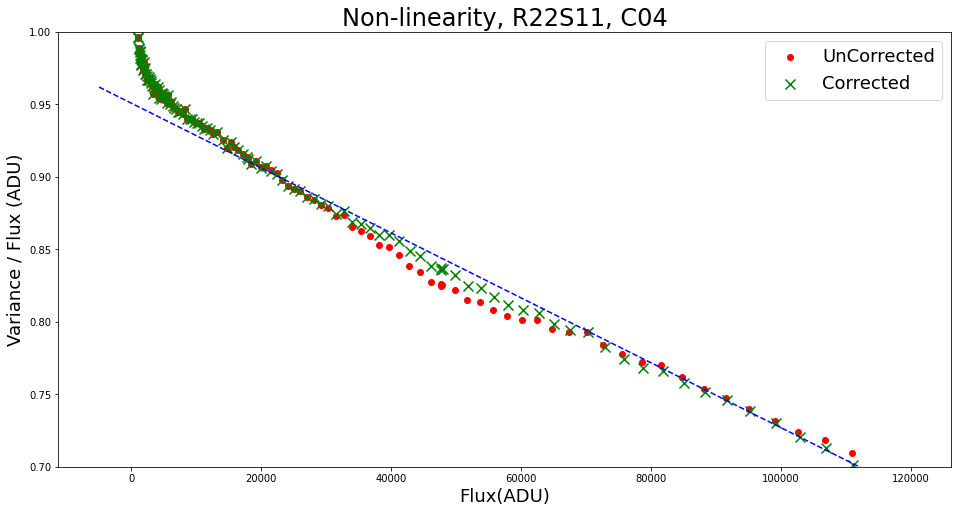

In [11]:
# Now we look at how well this has corrected.
# This plot is similar to Figure 3 in Astier, et.al.
# As Pierre has pointed out, we correct the flux with:
# Corrected flux = f(x), where x is the measured flux, and
# Corrected variance = (df/dx)^2 * var(x)
# This is an estimate.  What we need to do next is implement this in the
# ISR and correct the flux before caluclating the means and variances.

sder = interp.splder(s) # This takes the derivative
correctedMeans = interp.splev(means, s)
correctedVars = (interp.splev(means, sder))**2 * vars
fig = plt.figure(figsize = (16,8))
plt.title("Non-linearity, R22S11, C04", fontsize = 24)
cut_means = []
cut_vars = []
# Fit a line to the points outside the bump
for i, mean in enumerate(means):
    if (mean >20000 and mean <25000) or (mean >70000 and mean <100000):
        cut_means.append(mean)
        cut_vars.append(vars[i]/mean)
xplot = np.linspace(-5000,120000, 100)
these_coefs = np.polyfit(cut_means, cut_vars, 1)
yplot = these_coefs[1] + these_coefs[0] * xplot
plt.scatter(means,vars/means, color = 'red', marker = 'o', label = 'UnCorrected')
plt.scatter(correctedMeans, correctedVars/correctedMeans, color = 'green', marker = 'x', s = 100,label = 'Corrected')
plt.plot(xplot, yplot, ls = '--', color = 'blue')
plt.xlabel("Flux(ADU)", fontsize = 18)
plt.ylabel("Variance / Flux (ADU)", fontsize = 18)
plt.ylim(0.7, 1.0)
plt.legend(fontsize = 18)
plt.savefig(REPO_DIR + '/plots/NonLinearity_Correction_R22S11_C04_02Sep20.pdf')